In [1]:
install.packages("caret")
install.packages("gbm")
install.packages("ggplot2")


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘proxy’, ‘iterators’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘sparsevctrs’, ‘timeDate’, ‘e1071’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [2]:
# Nạp thư viện
library(caret)
library(gbm)
library(dplyr)
library(ggplot2)

Loading required package: ggplot2

Loading required package: lattice

Loaded gbm 2.2.2

This version of gbm is no longer under development. Consider transitioning to gbm3, https://github.com/gbm-developers/gbm3


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [4]:
# Đọc dữ liệu
data <- read.csv("students_habit_predict_mental_health.csv")


In [6]:
# Xác định target và features
target <- "mental_health_rating"
features <- setdiff(names(data), target)

In [7]:
# Tách tập train-test (80%-20%)
set.seed(42)
train_index <- createDataPartition(data[[target]], p = 0.8, list = FALSE)
train_data <- data[train_index, ]
test_data <- data[-train_index, ]

In [8]:
# Tạo grid các tham số để tuning
tune_grid <- expand.grid(
  n.trees = c(100, 200),
  interaction.depth = c(3, 5),
  shrinkage = c(0.05, 0.1, 0.2),
  n.minobsinnode = 10
)

In [9]:
# Cài đặt điều khiển huấn luyện
control <- trainControl(
  method = "cv", number = 5, verboseIter = TRUE
)

In [11]:
# Tách x và y từ train_data
x_train <- train_data[, features]
y_train <- train_data[[target]]


In [12]:
# Huấn luyện mô hình Gradient Boosting
set.seed(42)
gbm_model <- train(
  x = x_train,
  y = y_train,
  method = "gbm",
  trControl = control,
  tuneGrid = tune_grid,
  verbose = FALSE
)

+ Fold1: shrinkage=0.05, interaction.depth=3, n.minobsinnode=10, n.trees=200 
- Fold1: shrinkage=0.05, interaction.depth=3, n.minobsinnode=10, n.trees=200 
+ Fold1: shrinkage=0.05, interaction.depth=5, n.minobsinnode=10, n.trees=200 
- Fold1: shrinkage=0.05, interaction.depth=5, n.minobsinnode=10, n.trees=200 
+ Fold1: shrinkage=0.10, interaction.depth=3, n.minobsinnode=10, n.trees=200 
- Fold1: shrinkage=0.10, interaction.depth=3, n.minobsinnode=10, n.trees=200 
+ Fold1: shrinkage=0.10, interaction.depth=5, n.minobsinnode=10, n.trees=200 
- Fold1: shrinkage=0.10, interaction.depth=5, n.minobsinnode=10, n.trees=200 
+ Fold1: shrinkage=0.20, interaction.depth=3, n.minobsinnode=10, n.trees=200 
- Fold1: shrinkage=0.20, interaction.depth=3, n.minobsinnode=10, n.trees=200 
+ Fold1: shrinkage=0.20, interaction.depth=5, n.minobsinnode=10, n.trees=200 
- Fold1: shrinkage=0.20, interaction.depth=5, n.minobsinnode=10, n.trees=200 
+ Fold2: shrinkage=0.05, interaction.depth=3, n.minobsinnode=10,

In [13]:
# In tham số tốt nhất
cat("Best Hyperparameters:\n")
print(gbm_model$bestTune)

# Dự đoán trên tập test
pred <- predict(gbm_model, newdata = test_data)

# Đánh giá kết quả
mse <- mean((pred - test_data[[target]])^2)
r2 <- cor(pred, test_data[[target]])^2

cat("\n📊 Evaluation Metrics:\n")
cat("✅ MSE:", round(mse, 3), "\n")
cat("✅ R-Squared:", round(r2, 3), "\n")

Best Hyperparameters:
  n.trees interaction.depth shrinkage n.minobsinnode
6     200                 3       0.1             10

📊 Evaluation Metrics:
✅ MSE: 4.867 
✅ R-Squared: 0.43 


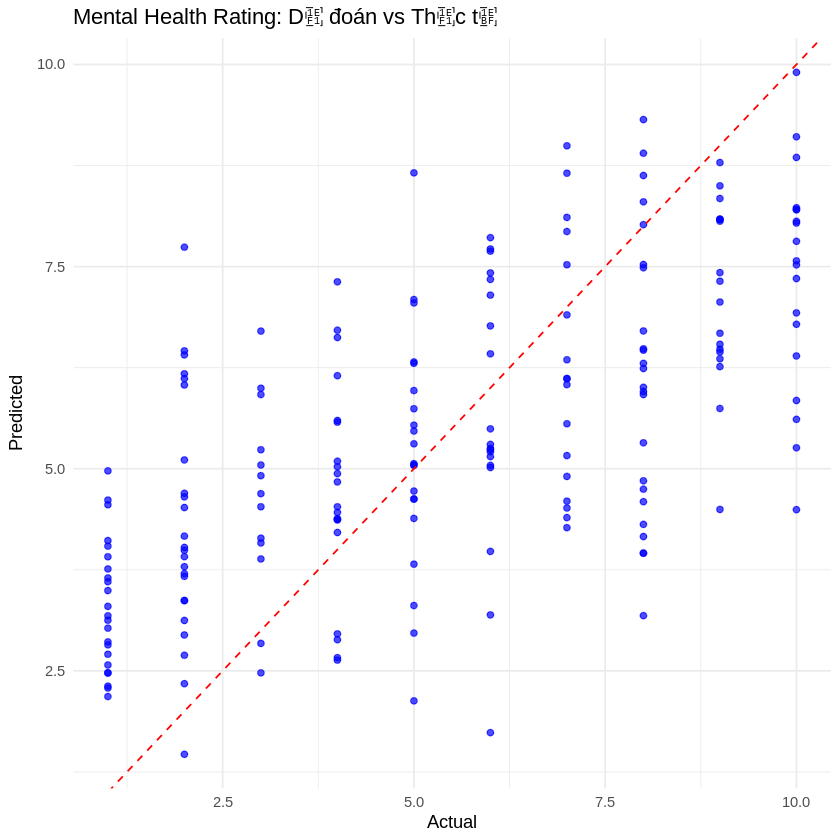

In [14]:
# Vẽ biểu đồ dự đoán vs thực tế
ggplot(data.frame(Actual = test_data[[target]], Predicted = pred), aes(x = Actual, y = Predicted)) +
  geom_point(color = "blue", alpha = 0.7) +
  geom_abline(intercept = 0, slope = 1, color = "red", linetype = "dashed") +
  ggtitle("Mental Health Rating: Dự đoán vs Thực tế") +
  theme_minimal()